In [1]:
import sys
sys.path.append('..')
from src.pomdp import *

import numpy as np

# POMDP Toy Problem

Symmetric 3 state, 2 action model

## Model definition

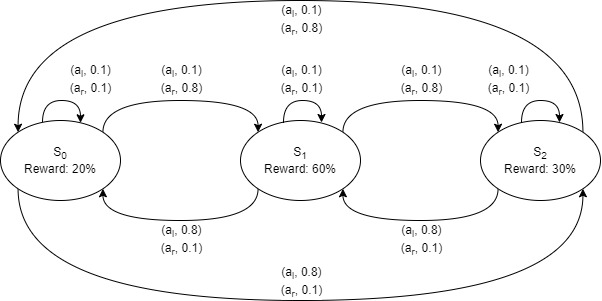

In [2]:
ACTION_COUNT = 2
STATE_COUNT = 3

In [3]:
# 80% chance of success, 10% land in other tile, 10% stay in place
MOVE_RND = 0.8
def transition_function(s, a, s_p):
    s_a = (s + (-1 if a == 0 else 1)) % STATE_COUNT # Left and right movement
    s_a = s_a if s_a >= 0 else s_a + STATE_COUNT
    
    if s_a == s_p:
        return MOVE_RND
    else:
        return round((1.0 - MOVE_RND) / (STATE_COUNT - 1), 1)

# Setup table to speedup computation
transition_table = np.zeros(shape=(STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            transition_table[s,a,s_p] = transition_function(s,a,s_p)

# Test with action 0, ie: LEFT
transition_table[:,0,:]

array([[0.1, 0.1, 0.8],
       [0.8, 0.1, 0.1],
       [0.1, 0.8, 0.1]])

In [4]:
OBS_RND = 0.7 # 70% of observation success

observation_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s_p in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for o in range(STATE_COUNT):
            observation_table[s_p, a, o] = OBS_RND if s_p == o else (1.0 - OBS_RND) / (STATE_COUNT - 1)
          
observation_table[:,0,:]

array([[0.7 , 0.15, 0.15],
       [0.15, 0.7 , 0.15],
       [0.15, 0.15, 0.7 ]])

In [5]:
REWARD_PROBS = [0.2, 0.6, 0.3]

reward_table = np.zeros((STATE_COUNT, ACTION_COUNT, STATE_COUNT))
for s in range(STATE_COUNT):
    for a in range(ACTION_COUNT):
        for s_p in range(STATE_COUNT):
            reward_table[s,a,s_p] = REWARD_PROBS[s_p]
        
reward_table

array([[[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]],

       [[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]],

       [[0.2, 0.6, 0.3],
        [0.2, 0.6, 0.3]]])

In [6]:
states = ['s0','s1','s2']
actions = ['left', 'right']
observations = ['s0', 's1', 's2']

model = Model(states, actions, observations, transition_table, reward_table, observation_table, probabilistic_rewards=True)

## Solving

In [7]:
solver = PBVI_Solver(8,4)

In [8]:
value_function, solve_history = solver.solve(model)

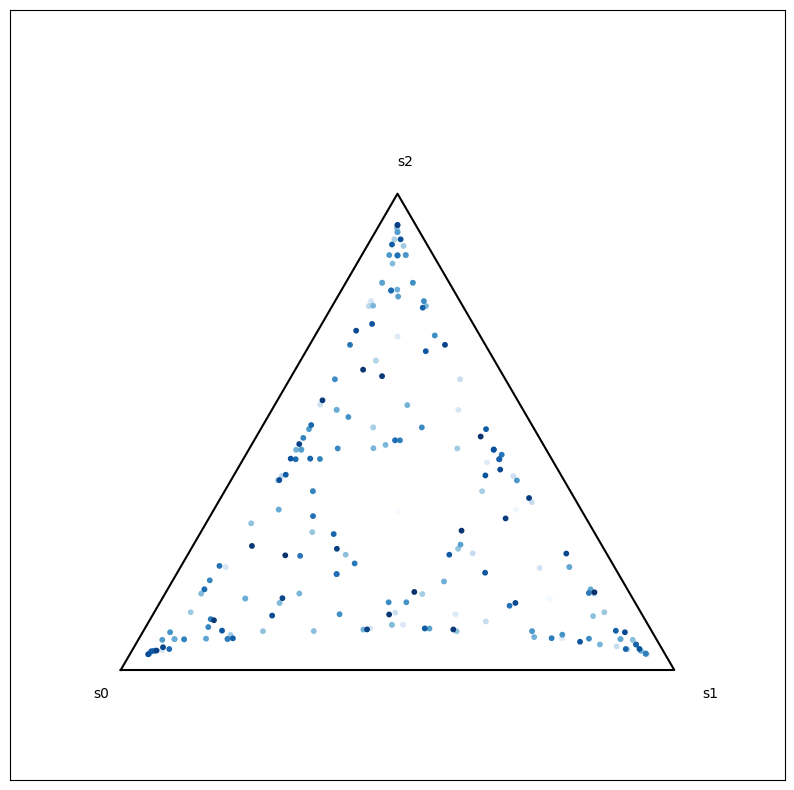

In [9]:
solve_history.plot_belief_set(10)

In [10]:
value_function

[AlphaVector([3.86561535, 3.81721677, 4.01871989]),
 AlphaVector([3.98687095, 3.88341934, 3.80236606]),
 AlphaVector([4.02428098, 3.85737715, 3.81300065]),
 AlphaVector([4.02423089, 3.85741835, 3.81333677]),
 AlphaVector([3.85737715, 3.81300065, 4.02428098]),
 AlphaVector([3.86543901, 3.81462793, 4.01964334]),
 AlphaVector([4.01942554, 3.8657259 , 3.81463714]),
 AlphaVector([3.85741835, 3.81333677, 4.02423089]),
 AlphaVector([4.02363706, 3.85742977, 3.81555578]),
 AlphaVector([3.86311111, 3.8178214 , 4.01889258]),
 AlphaVector([3.97415792, 3.89521055, 3.72405444]),
 AlphaVector([4.01964334, 3.86543901, 3.81462793]),
 AlphaVector([3.85523464, 3.81614529, 4.02361596]),
 AlphaVector([3.98548606, 3.88374557, 3.80164005]),
 AlphaVector([4.01870014, 3.8658408 , 3.81692795]),
 AlphaVector([3.86572583, 3.81463642, 4.01942577]),
 AlphaVector([3.97415835, 3.89521052, 3.72405448]),
 AlphaVector([4.02428645, 3.85732213, 3.81293595]),
 AlphaVector([4.02427574, 3.85757649, 3.81273925]),
 AlphaVector

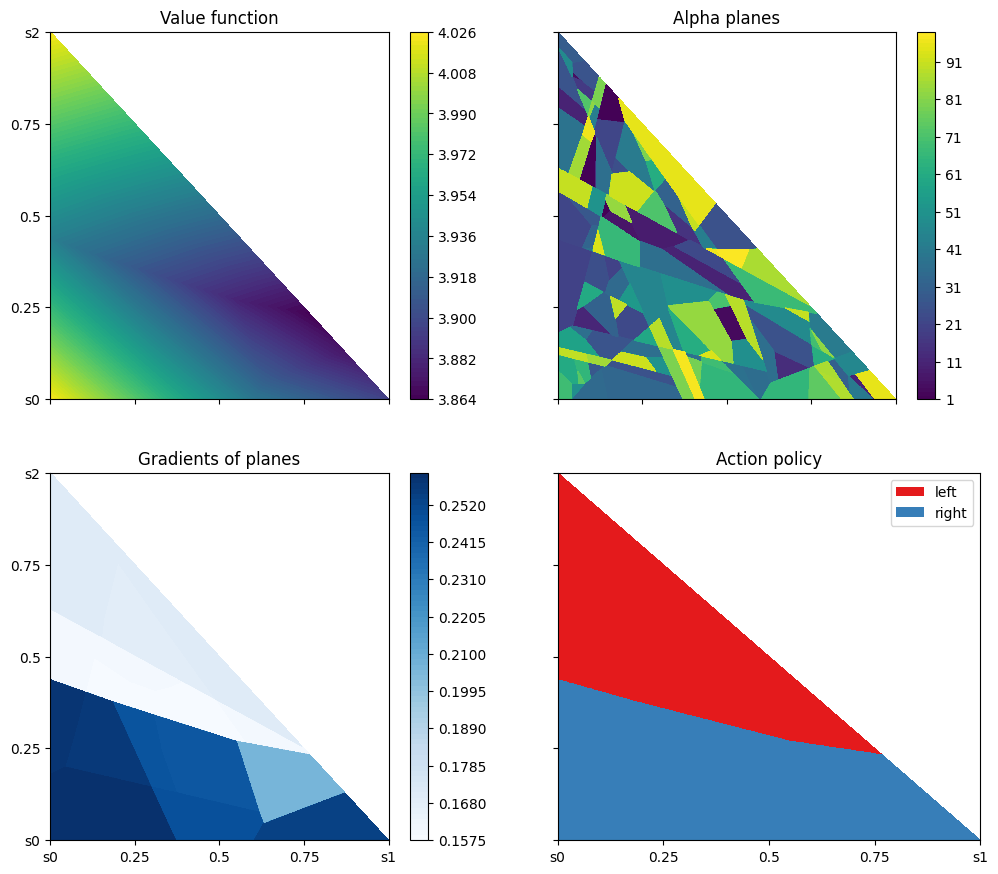

In [11]:
solve_history.plot_solution(3, plot_belief=False)

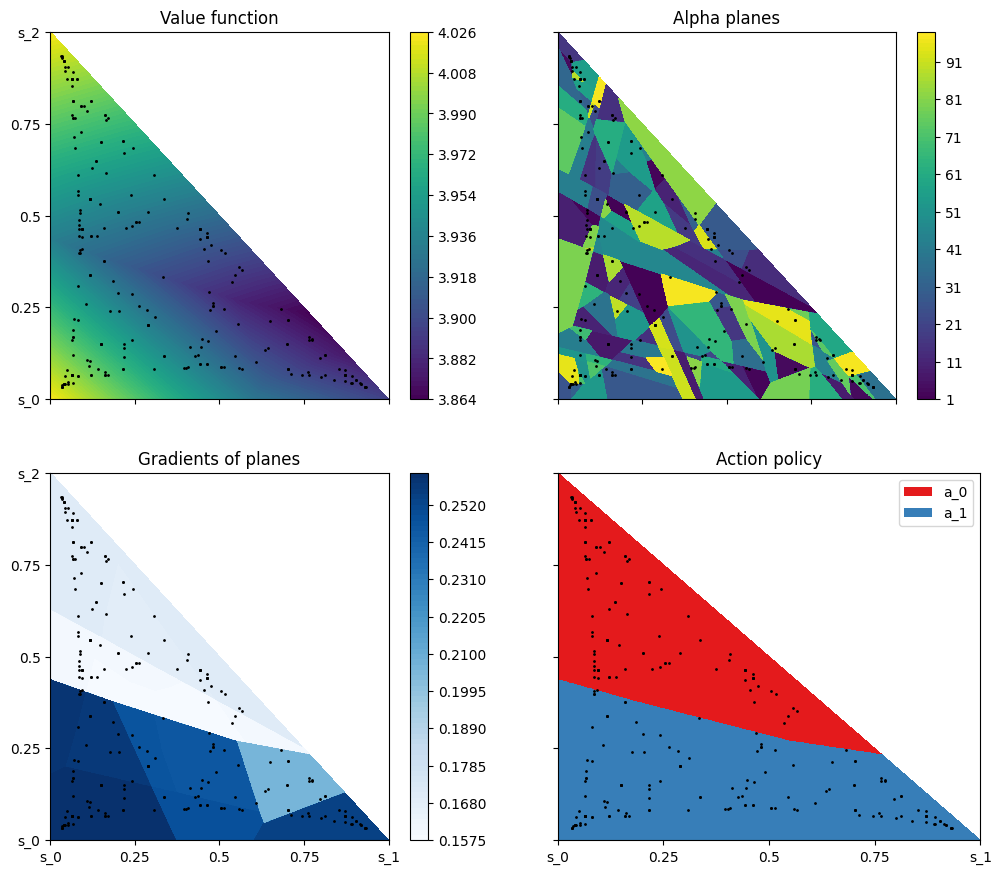

In [12]:
value_function.plot(3, belief_set=solve_history.explored_beliefs)